In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN, HDBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dic = torch.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/041124_eval_061024_cont2/showers_df_evaluation/graphs/0_2_0.pt", map_location='cpu')


In [ ]:
g = dic["graph"]
betas  = torch.sigmoid(dic["graph"].ndata["beta"])
X  = dic["graph"].ndata["coords"]
clustering_mode = "clustering_normal"

db = HDBSCAN(min_cluster_size=8, min_samples=8,cluster_selection_epsilon=0.1 ).fit(X)
labels_hdb = db.labels_ +1
labels_hdb = np.reshape(labels_hdb, (-1))
labels_hdb = torch.Tensor(labels_hdb).long()


In [152]:
tracks_label = scatter_add((dic["graph"].ndata["hit_type"] == 1)*(dic["graph"].ndata["particle_number"]), labels_hdb).int()
tracks_label = tracks_label-1
tracks_label[tracks_label<0]=0
tracks_label = torch.tensor(tracks_label)
print(tracks_label)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        11, 10,  0, 28,  0,  0,  0,  0,  0,  0,  9,  4,  0,  2,  3,  1,  0],
       dtype=torch.int32)


/tmp/mgarciam/ipykernel_312733/2715808151.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [146]:
matched_es

tensor([ 0.,  0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  0., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29.,  0.,  0.,  0., 33.,  0.,  0., 36., 37., 38.,  0., 40.,  0.])

In [147]:
matched_es = torch.zeros(len(torch.unique(dic["graph"].ndata["particle_number"])))
matched_es1 = torch.zeros(len(torch.unique(dic["graph"].ndata["particle_number"])))
matched_es[torch.Tensor(row_ind_hdb).long()]=torch.Tensor(row_ind_hdb)

In [148]:
matched_es1[torch.Tensor(row_ind_hdb).long()] = tracks_label[torch.tensor(col_ind_hdb+1).long()].float()

In [171]:
1.0*(matched_es1==matched_es)

tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 1., 0., 1.])

In [172]:
matched_es1

tensor([ 0.,  0.,  2.,  3.,  4.,  0.,  0.,  0.,  0.,  0., 10., 11.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        28.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [150]:
matched_es

tensor([ 0.,  0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  0., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29.,  0.,  0.,  0., 33.,  0.,  0., 36., 37., 38.,  0., 40.,  0.])

In [ ]:
# add a flag to check if the right tracks are added to the correcct cluster 

In [161]:
torch.sum(g.ndata['e_hits'][g.ndata['particle_number']==13])

tensor(30.9488)

In [164]:
g.ndata['h'][:,-1][g.ndata["particle_number"]==1]

tensor([0.3030, 0.0000, 0.0000, 0.0000])

In [169]:

import pandas as pd
import plotly.express as px
from src.logger.plotting_tools import shuffle_truth_colors

mask = (g.ndata['particle_number']==13)+(g.ndata['particle_number']==2)
tidx =  1*(g.ndata['particle_number'][mask].view(-1,1)) #1*(g.ndata['hit_type'][mask].view(-1,1)) #1*(labels_hdb[mask].view(-1,1))  #
#tidx =    1*(g.ndata['hit_link_modified'][mask].view(-1,1))+1
features =   (g.ndata['e_hits'][mask].view(-1,1))+g.ndata['h'][:,-1][mask].view(-1,1)/20
cellid= labels_hdb[mask].view(-1,1)
X = g.ndata["pos_hits_xyz"][mask] #[mask]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
            "cellid":cellid.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx", "cellid"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_white",
range_color=[0,4],
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [67]:
betas  = torch.sigmoid(dic["graph"].ndata["beta"])
X  = dic["graph"].ndata["coords"]
clustering_mode = "clustering_normal"

db = HDBSCAN(min_cluster_size=8, min_samples=8, cluster_selection_epsilon=0.10).fit(X)
labels_hdb = db.labels_ +1
labels_hdb = np.reshape(labels_hdb, (-1))
labels_hdb = torch.Tensor(labels_hdb).long()

labels_pandora = dic["graph"].ndata["pandora_cluster"].long()
labels_pandora = labels_pandora+1
map_from = list(np.unique(labels_pandora))
cluster_id = map(lambda x: map_from.index(x), labels_pandora)
labels_pandora = torch.Tensor(list(cluster_id)).long()
labels = labels_hdb 
model_output = torch.cat((dic["graph"].ndata["coords"], dic["graph"].ndata["beta"].view(-1,1)), dim=1)
particle_ids = torch.unique(dic["graph"].ndata["particle_number"])
shower_p_unique_hdb = torch.unique(labels)
from src.layers.inference_oc import obtain_intersection_matrix, obtain_union_matrix, match_showers, generate_showers_data_frame
shower_p_unique_hdb, row_ind_hdb, col_ind_hdb, i_m_w_hdb, iou_m = match_showers(
    labels_hdb,
    dic,
    particle_ids,
    model_output,
    0,
    0,
    None,
    tracks=True,
    hdbscan=True,
)



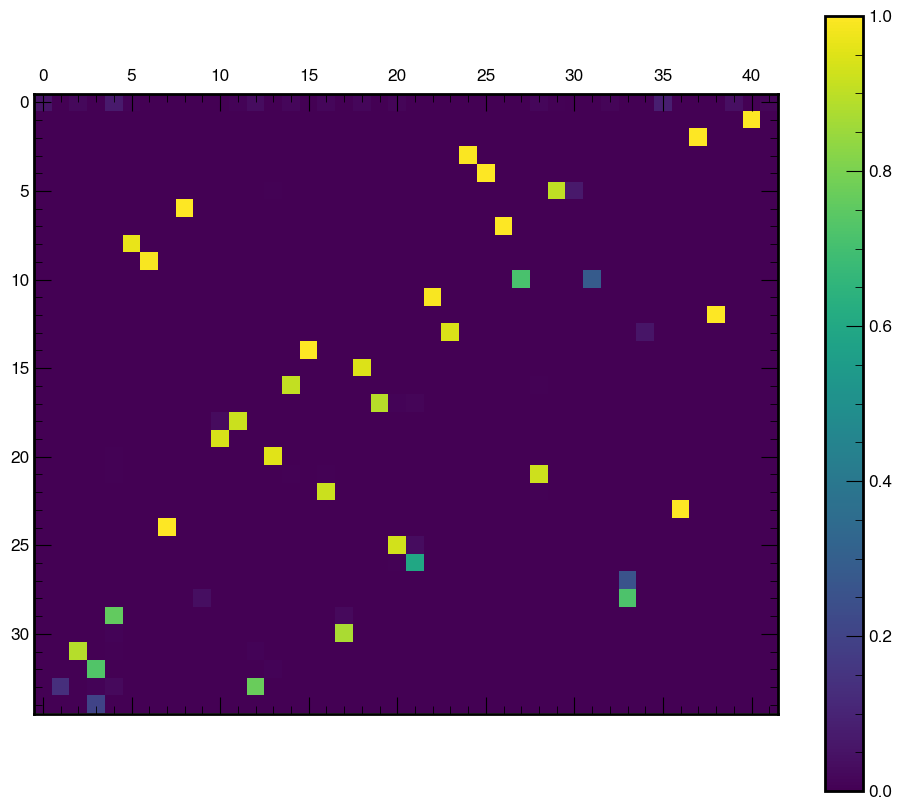

In [93]:
plt.matshow(iou_m)
plt.colorbar()
plt.show()

In [59]:
labels = labels_hdb
dic["graph"].ndata["correction"] = torch.ones_like(dic["graph"].ndata["beta"])
model_output = torch.cat((dic["graph"].ndata["coords"],dic["graph"].ndata["beta"].view(-1,1)), dim=1)
particle_ids = torch.unique(dic["graph"].ndata["particle_number"])


df_event1, number_of_showers_total1 = generate_showers_data_frame(
                labels_hdb,
                dic,
                shower_p_unique_hdb,
                particle_ids,
                row_ind_hdb,
                col_ind_hdb,
                i_m_w_hdb,
                e_corr=None,
                number_of_showers_total=0,
                step=0,
                number_in_batch=0,
                tracks=True,
                ec_x=None,
                shap_vals=None,
                pred_pos=None,
                save_plots_to_folder=None,
            )


(
    shower_p_unique_pandora,
    row_ind_pandora,
    col_ind_pandora,
    i_m_w_pandora,
    iou_m_pandora,
) = match_showers(
    labels_pandora,
    dic,
    particle_ids,
    model_output,
    0,
    0,
    None,
    pandora=True,
    tracks=True,
)


In [60]:
df_event_pandora = generate_showers_data_frame(
                    labels_pandora,
                    dic,
                    shower_p_unique_pandora,
                    particle_ids,
                    row_ind_pandora,
                    col_ind_pandora,
                    i_m_w_pandora,
                    pandora=True,
                    tracking=True,
                    step=0,
                    number_in_batch=0,
                    tracks=True,
                    save_plots_to_folder=None,
                )

In [61]:
df_event_pandora

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,step,number_batch,is_track_in_cluster,vertex,true_pos
0,1.293392,0.762220,0.660452,0.574678,0.710045,1.267883,"[0.19652383029460907, 0.043364573270082474, 1....","[12.749489784240723, 3.870055913925171, 90.631...",-211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.20177128911018372, 0.047381382435560226, 1...."
1,2.525085,1.797971,1.765863,1.760058,1.940648,2.479401,"[0.10421797633171082, -1.709091305732727, -1.7...","[2.2008652687072754, -35.260005950927734, -26....",211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.10905272513628006, -1.739119052886963, -1.8..."
2,22.181610,23.735584,23.659502,22.236067,25.497072,25.497072,"[3.70552134513855, 8.358428955078125, 23.80142...","[288.2773742675781, 1156.871337890625, 2917.61...",130.0,0.0,0.0,0.0,"[0.20116958022117615, 0.7169902920722961, 11.3...","[2.258039951324463, 7.909945011138916, 20.5939..."
3,17.966957,18.572468,17.172470,16.750595,18.037653,18.080175,"[2.617431402206421, 6.419255256652832, 16.6978...","[4.951898574829102, 12.301305770874023, 41.522...",211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[2.6053683757781982, 6.377560138702393, 16.593..."
4,7.109093,8.705958,8.048901,7.362743,9.024585,7.139328,"[0.8805995583534241, 2.19671630859375, 6.73419...","[19.12004280090332, 49.0086669921875, 158.9602...",-211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.8724053502082825, 2.189537286758423, 6.7055..."
5,4.818478,4.995217,4.867236,4.785666,4.953731,4.953731,"[0.5426511764526367, 1.996581792831421, 4.5009...","[285.9908447265625, 1054.607421875, 2378.76342...",22.0,0.0,0.0,0.0,"[0.20122821629047394, 0.7171769738197327, 11.3...","[0.5293598175048828, 1.9469305276870728, 4.375..."
6,0.995382,1.234113,1.220292,1.220292,1.320498,0.976950,"[0.1439352184534073, -0.18291811645030975, 0.9...","[21.066024780273438, -29.113340377807617, 158....",211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.1397477090358734, -0.1882573515176773, 0.95..."
7,0.534147,0.474091,0.471227,0.471227,0.511549,0.503308,"[0.08905505388975143, 0.3864462375640869, 0.27...","[2.899038076400757, 13.151701927185059, 20.184...",-211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.09354919195175171, 0.4134715497493744, 0.29..."
8,0.778782,0.635287,0.436027,0.436027,0.464033,0.778001,"[-0.3331366777420044, -0.2741556465625763, -0....","[-27.41197967529297, -23.041074752807617, -41....",-211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[-0.33853474259376526, -0.2754098176956177, -0..."
9,7.101606,6.311375,5.245873,5.245873,5.337429,7.132380,"[-1.0044113397598267, -4.471796035766602, -5.4...","[-2.905517816543579, -13.14902400970459, -5.57...",-211.0,0.0,0.0,1.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[-1.0029903650283813, -4.45133113861084, -5.43..."


In [62]:
df_event1

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,vertex,true_pos
0,1.293392,0.762220,0.781709,0.748238,-211.0,1.0,0.781709,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.20177128911018372, 0.047381382435560226, 1...."
1,2.525085,1.797971,1.787799,1.781994,211.0,1.0,1.787799,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.10905272513628006, -1.739119052886963, -1.8..."
2,22.181610,23.735584,22.521402,21.247686,130.0,1.0,22.521402,0.0,0.0,0.0,"[0.20116958022117615, 0.7169902920722961, 11.3...","[2.258039951324463, 7.909945011138916, 20.5939..."
3,17.966957,18.572468,16.023018,16.023018,211.0,1.0,16.023018,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[2.6053683757781982, 6.377560138702393, 16.593..."
4,7.109093,8.705958,7.267987,7.092271,-211.0,1.0,7.267987,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.8724053502082825, 2.189537286758423, 6.7055..."
5,4.818478,4.995217,4.854444,4.807625,22.0,1.0,4.854444,0.0,0.0,0.0,"[0.20122821629047394, 0.7171769738197327, 11.3...","[0.5293598175048828, 1.9469305276870728, 4.375..."
6,0.995382,1.234113,1.245928,1.234113,211.0,1.0,1.245928,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.1397477090358734, -0.1882573515176773, 0.95..."
7,0.534147,0.474091,0.474091,0.474091,-211.0,1.0,0.474091,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[0.09354919195175171, 0.4134715497493744, 0.29..."
8,0.778782,0.635287,0.635287,0.635287,-211.0,1.0,0.635287,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[-0.33853474259376526, -0.2754098176956177, -0..."
9,7.101606,6.311375,5.793411,5.793411,-211.0,1.0,5.793411,0.0,0.0,0.0,"[0.20115306973457336, 0.7169324159622192, 11.3...","[-1.0029903650283813, -4.45133113861084, -5.43..."


In [72]:
mask = ~np.isnan(df_event_pandora["reco_showers_E"])
eff = np.sum(~np.isnan(df_event_pandora["pred_showers_E"][mask].values)) / len(
    df_event_pandora["pred_showers_E"][mask].values
)
eff

0.8333333333333334

In [122]:
dic["graph"].ndata["pandora_pfo"][dic["graph"].ndata["particle_number"]==8]

tensor([11., 11., 11., -1., 11., 11., 11., 11., 11., 11., -1., 11., -1.,  7.,
        -1., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11.,  7.])

In [123]:
dic["graph"].ndata["particle_number"][dic["graph"].ndata["pandora_pfo"]==11]

tensor([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
        8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
        8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 7., 7., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [70]:
10,7,6, 26, 28

(4, 7, 11, 10)

In [71]:
# dic["graph"].ndata["particle_number"][dic["graph"].ndata["pandora_pfo"]==5]

In [88]:
df_event_pandora[np.isnan(df_event_pandora.pred_showers_E)]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pid,step,number_batch,is_track_in_cluster,true_pos
9,2.329102,2.640893,NaN,NaN,NaN,NaN,"[nan, nan, nan]",130.0,0.0,0.0,0.0,"[-0.7651358246803284, 0.6109310984611511, 0.20..."
15,1.925326,0.762547,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,0.0,0.0,0.0,"[-0.9650052189826965, 0.2598087787628174, 0.03..."
30,1.185284,0.086943,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,0.0,0.0,0.0,"[-0.704387903213501, 0.471829354763031, 0.5302..."
37,3.284257,2.630318,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.9655623435974121, 0.20867878198623657, 0.1..."
38,0.207086,0.208681,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.8510399460792542, 0.5210474133491516, -0.0..."
39,0.120614,0.127668,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.8884783387184143, 0.4343204200267792, 0.14..."


In [73]:
df_event1[np.isnan(df_event1.pred_showers_E)]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,true_pos
8,1.856086,0.322600,NaN,NaN,2112.0,NaN,NaN,0.0,0.0,0.0,"[-0.8380269408226013, 0.5166364908218384, -0.1..."
30,1.185284,0.086943,NaN,NaN,2112.0,NaN,NaN,0.0,0.0,0.0,"[-0.704387903213501, 0.471829354763031, 0.5302..."


In [9]:
mask = ~np.isnan(df_event1["reco_showers_E"])
eff = np.sum(~np.isnan(df_event1["pred_showers_E"][mask].values)) / len(
    df_event1["pred_showers_E"][mask].values
)
eff

0.95

In [16]:
# matched_showers = ~np.isnan(df_event_pandora.e_pred_and_truth)
# matched_showers1 = ~np.isnan(df_event1.e_pred_and_truth)
# import seaborn as sns
# sns.histplot(df_event_pandora[matched_showers].pred_showers_E/df_event_pandora[matched_showers].reco_showers_E, binwidth=0.05)
# sns.histplot(df_event1[matched_showers1].pred_showers_E/df_event1[matched_showers1].reco_showers_E, binwidth=0.05)

In [27]:
df_event1

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,vertex,true_pos
0,21.041212,19.520899,17.860666,17.812820,-321.0,1.0,17.860666,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-9.404985427856445, -6.865049839019775, 17.51..."
1,3.884395,3.334723,3.267396,3.267396,321.0,1.0,3.267396,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-1.6388781070709229, -1.2186970710754395, 3.2..."
2,4.183385,2.653735,2.306823,1.966029,321.0,1.0,2.306823,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[2.852459192276001, 2.038388252258301, -2.2283..."
3,23.835997,23.925329,22.657440,22.477093,22.0,1.0,22.657440,0.0,0.0,0.0,"[-0.12750683724880219, -0.7845514416694641, -1...","[-9.869407653808594, -8.231571197509766, 20.07..."
4,5.380503,5.266236,4.932422,4.604086,22.0,1.0,4.932422,0.0,0.0,0.0,"[-0.12750683724880219, -0.7845514416694641, -1...","[-2.240812301635742, -1.7979025840759277, 4.54..."
5,1.216162,1.661927,1.661927,1.661927,-211.0,1.0,1.661927,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.3731476366519928, -0.6243683695793152, 0.9..."
6,0.607246,0.783801,0.783801,0.783801,211.0,1.0,0.783801,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[0.17441381514072418, -0.08467189967632294, 0...."
7,0.599934,0.551861,0.551861,0.551861,-211.0,1.0,0.551861,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.24781310558319092, 0.053123150020837784, 0..."
8,0.505133,0.582247,0.582247,0.582247,22.0,1.0,0.582247,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.1888885647058487, 0.2478916198015213, -0.3..."
9,4.654628,3.683563,3.302284,3.064744,211.0,1.0,3.302284,0.0,0.0,0.0,"[-0.12657997012138367, -0.783784031867981, -19...","[3.1898109912872314, 2.2069272994995117, -2.56..."


In [11]:
df_event_pandora[np.isnan(df_event_pandora.pred_showers_E)]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pid,step,number_batch,is_track_in_cluster,true_pos
9,2.329102,2.640893,NaN,NaN,NaN,NaN,"[nan, nan, nan]",130.0,0.0,0.0,0.0,"[-0.7651358246803284, 0.6109310984611511, 0.20..."
15,1.925326,0.762547,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,0.0,0.0,0.0,"[-0.9650052189826965, 0.2598087787628174, 0.03..."
30,1.185284,0.086943,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,0.0,0.0,0.0,"[-0.704387903213501, 0.471829354763031, 0.5302..."
37,3.284257,2.630318,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.9655623435974121, 0.20867878198623657, 0.1..."
38,0.207086,0.208681,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.8510399460792542, 0.5210474133491516, -0.0..."
39,0.120614,0.127668,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.8884783387184143, 0.4343204200267792, 0.14..."


In [27]:
np.nansum(df_event_pandora.pandora_calibrated_pfo)/np.nansum(df_event_pandora.true_showers_E)

1.0287228

In [28]:
np.nansum(df_event1.pred_showers_E)/np.nansum(df_event1.reco_showers_E)

0.96292645

<Axes: ylabel='Count'>

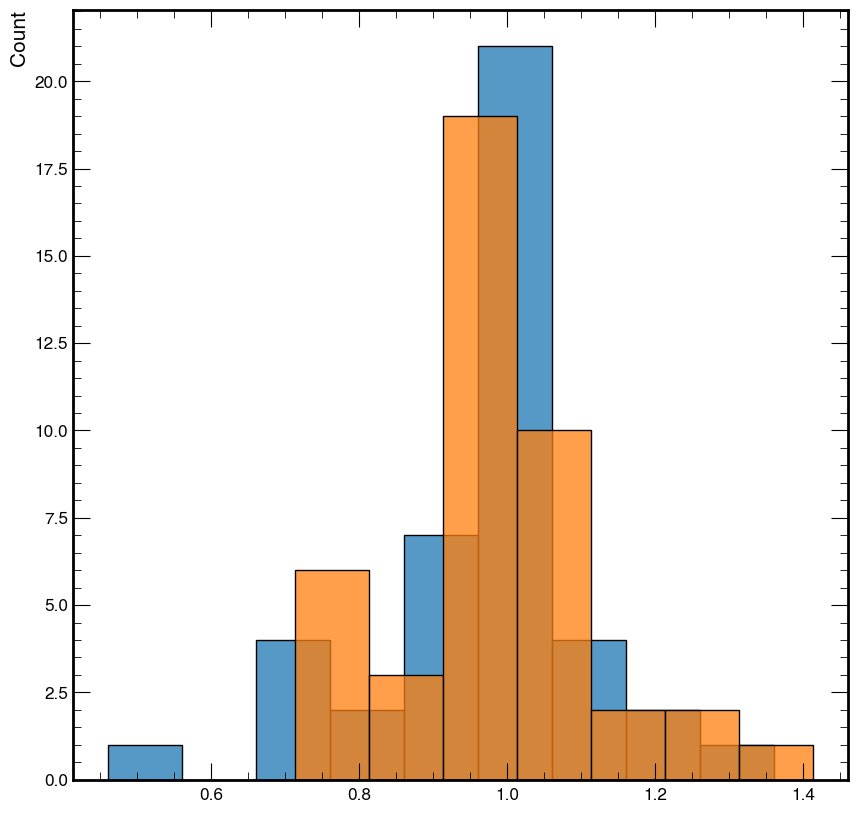

In [18]:
sl_p = df_event_pandora[~np.isnan(df_event_pandora.e_pred_and_truth)]
sl = df_event[~np.isnan(df_event.e_pred_and_truth)]
import seaborn as sns
sns.histplot(sl_p.pred_showers_E/sl_p.reco_showers_E,binwidth=0.1)
sns.histplot(sl.pred_showers_E/sl.reco_showers_E, binwidth=0.1)

In [79]:
np.nansum(df_event1.pred_showers_E)/np.nansum(df_event1.reco_showers_E)

0.96127325

In [80]:
np.nansum(df_event_pandora.pred_showers_E)/np.nansum(df_event_pandora.reco_showers_E)

0.98057485

In [6]:
# weights = torch.ones_like(dic["graph"].ndata["particle_number"])
# for i in torch.unique(dic["graph"].ndata["particle_number"]):   
#     mask  = dic["graph"].ndata["particle_number"] == i
#     mask2 = mask* (dic["graph"].ndata["hit_type"]==1)
#     mask3 = mask* (dic["graph"].ndata["hit_type"]==0)
#     a = dic["graph"].ndata["hit_type"][mask]
#     total_hits = len(a)
#     n_vtx_hits = torch.sum(a)
#     n_dch = total_hits-torch.sum(a)
#     print(i, total_hits,n_vtx_hits,n_dch)
#     if n_dch>0 and n_vtx_hits>0:
#             weights[mask3] = total_hits/(2*n_dch)
#             weights[mask2] = total_hits/(2*n_vtx_hits)
    

In [13]:
dic["part_true"].pid

tensor([[   22.],
        [  130.],
        [  130.],
        [  -11.],
        [   22.],
        [ 2112.],
        [   22.],
        [  130.],
        [ 2112.],
        [  130.],
        [ -211.],
        [ -211.],
        [  130.],
        [ 2112.],
        [   11.],
        [ 2112.],
        [   11.],
        [ -211.],
        [ 2112.],
        [  211.],
        [   22.],
        [   11.],
        [   22.],
        [  -11.],
        [   22.],
        [ 2212.],
        [  130.],
        [ 2112.],
        [ 2212.],
        [ 2112.],
        [ 2112.],
        [-2212.],
        [-2212.],
        [ -211.],
        [ 2112.],
        [ -211.],
        [   22.],
        [   22.],
        [   22.],
        [   22.]])

In [27]:
labels[labels==11]=0

In [81]:
dic["graph"].ndata['particle_number'][dic["graph"].ndata['particle_number']==7]=15

In [84]:
dic["graph"].ndata['particle_number'][dic["graph"].ndata['particle_number']==3]=10

In [130]:
dic["part_true"].E

tensor([[2.1808e+01],
        [3.2622e+01],
        [1.0811e+00],
        [4.5706e+01],
        [2.0874e+00],
        [9.2428e+00],
        [2.1900e+01],
        [1.5027e+00],
        [1.8626e+01],
        [5.8944e+00],
        [6.7888e-01],
        [3.9222e+01],
        [1.1037e+00],
        [4.8915e+00],
        [4.5490e-02]])

In [128]:
pp = [8,1]
mask = (dic["graph"].ndata['particle_number'].view(-1) ==1)
# mask =  (labels == 12)+(labels == 17)+(labels == 18) +(labels == 9) 
for i in pp:
    mask = mask +  (dic["graph"].ndata['particle_number'].view(-1) ==i)
tidx = dic["graph"].ndata['particle_number'][mask].view(-1,1) #1*(dic["graph"].ndata['particle_number'][mask].view(-1,1)) #(labels.view(-1,1))
features =  dic["graph"].ndata['e_hits'][mask]#torch.sigmoid(dic["graph"].ndata["beta"][mask])
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx,
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_white",
range_color=[0,12],
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [187]:
dic["part_true"].pid

tensor([[  211.],
        [  -11.],
        [  130.],
        [  -11.],
        [  130.],
        [   22.],
        [   22.],
        [ 2112.],
        [-2212.],
        [   22.],
        [   22.],
        [   22.]])

In [64]:
from src.logger.plotting_tools import shuffle_truth_colors
pp = []
mask =  (dic["graph"].ndata['particle_number'].view(-1)!=-1) #+(dic["graph"].ndata['pandora_pfo'].view(-1)==33)
for i in pp:
    mask = mask +  (dic["graph"].ndata['particle_number'].view(-1) ==i)
#mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #+(dic["graph"].ndata['particle_number'].view(-1) ==25)   + (dic["graph"].ndata['particle_number'].view(-1) ==20)+ (dic["graph"].ndata['particle_number'].view(-1) ==12)+ (dic["graph"].ndata['particle_number'].view(-1) ==15)
tidx =  dic["graph"].ndata['particle_number'].view(-1,1)[mask]#1*(dic["graph"].ndata['particle_number'].view(-1,1)[mask])# +1*(dic["graph"].ndata['particle_number_nomap'].view(-1,1)[mask]==189)#(labels_pandora.view(-1,1))
features = torch.sigmoid(dic["graph"].ndata["beta"][mask]).view(-1,1)
X =dic["graph"].ndata["pos_hits_xyz"][mask]#dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [186]:
dic

{'graph': Graph(num_nodes=2133, num_edges=0,
       ndata_schemes={'h': Scheme(shape=(9,), dtype=torch.float32), 'pos_hits_xyz': Scheme(shape=(3,), dtype=torch.float32), 'pos_pxpypz': Scheme(shape=(3,), dtype=torch.float32), 'radial_distance': Scheme(shape=(), dtype=torch.float32), 'radial_distance_exp': Scheme(shape=(), dtype=torch.float32), 'hit_type': Scheme(shape=(), dtype=torch.int64), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'chi_squared_tracks': Scheme(shape=(), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'hit_link_modified': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32), 'pandora_cluster': Scheme(shape=(), dtype=torch.float32), 'pandora_pfo': Scheme(shape=(), dtype=torch.float32), 'pandora_cluster_energy': Scheme(shape=(), dtype=torch.float32), 'pandora_pfo_energy': Scheme(shape=(), dtype=torch.float32), 'pos_pxpypz_at_vertex': Scheme(shape=(3,), dtype=torch.float32), 'final_cl

In [72]:
torch.sum(dic["graph"].ndata['hit_type'][mask]==2),torch.sum(dic["graph"].ndata['hit_type'][mask]==3)

(tensor(58), tensor(193))

In [78]:
ecal_hits = scatter_add(1*(dic["graph"].ndata['hit_type']==2), dic["graph"].ndata['particle_number'].view(-1).long())
hcal_hits = scatter_add(1*(dic["graph"].ndata['hit_type']==3), dic["graph"].ndata['particle_number'].view(-1).long())

In [82]:
weights = torch.ones_like(dic["graph"].ndata['hit_type'])

In [93]:
print(ecal_hits)
print(hcal_hits)
weight_ecal_per_object = 1.0*ecal_hits.clone()+1
weight_hcal_per_object = 1.0*ecal_hits.clone()+1
mask =(ecal_hits>2)*(hcal_hits>2)
weight_ecal_per_object[mask] = (ecal_hits+hcal_hits)[mask]/(2*ecal_hits)[mask]
weight_hcal_per_object[mask] = (ecal_hits+hcal_hits)[mask]/(2*hcal_hits)[mask]
print(weight_ecal_per_object)
print(weight_hcal_per_object)


tensor([  0,  58, 445,   0,   0,  85, 138,  77,  36,  41])
tensor([  0, 193,  78,   4, 109,   0,  58,   1,   0,   0])
tensor([ 1.0000,  2.1638,  0.5876,  1.0000,  1.0000, 86.0000,  0.7101, 78.0000,
        37.0000, 42.0000])
tensor([ 1.0000,  0.6503,  3.3526,  1.0000,  1.0000, 86.0000,  1.6897, 78.0000,
        37.0000, 42.0000])


In [92]:
2.1638*58+0.6503*193

251.00830000000002

In [11]:
dic["part_true"][:,5]


tensor([13.0880,  1.7113,  1.8285,  0.1050,  2.1278,  0.5404,  1.0237,  3.4199,
         1.0623,  0.6576,  0.9063,  0.2535,  0.3852,  0.8060,  8.1772,  5.2689,
         0.1015,  0.0384,  0.7845,  0.1765,  0.2769])

In [26]:
parents = dic["part_true"][:,-2]
print(parents)
particle_ids =  dic["part_true"][:, 4]
change_pairs = []
for indx, i in enumerate(parents):
    if torch.sum(particle_ids == i) > 0:
        change_pairs.append([parents[indx], particle_ids[indx]])
print(change_pairs)



tensor([ 24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  61.,  61.,  63.,
         65.,  66.,  66.,  68.,  69.,  70.,  72.,  77.,  80.,  67.,  67.,  67.,
        178.])
[[tensor(67.), tensor(176.)], [tensor(67.), tensor(177.)], [tensor(67.), tensor(178.)], [tensor(178.), tensor(179.)]]


In [25]:
particle_ids

tensor([ 62.,  64.,  67.,  71.,  73.,  75.,  78.,  79.,  81.,  84.,  85.,  86.,
         88.,  90.,  91.,  93.,  95.,  96.,  99., 105., 107., 176., 177., 178.,
        179.])

In [107]:
a = np.exp(np.arange(np.log(0.001), np.log(80), 0.5))

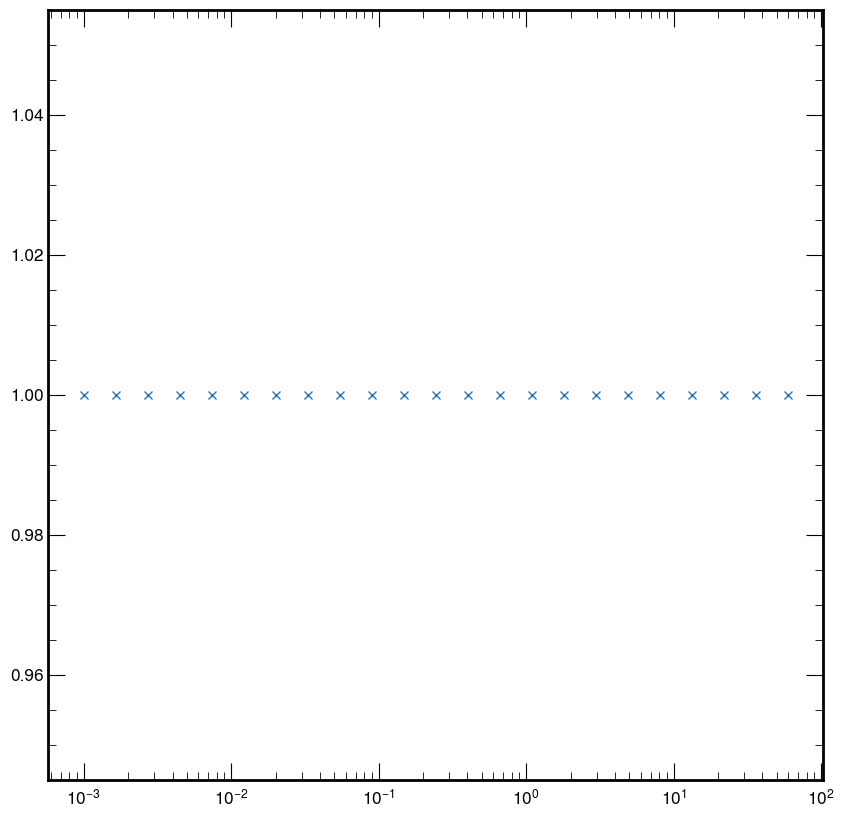

In [109]:
plt.plot(a,np.ones(len(a)),'x')
plt.xscale("log")

In [64]:
print(dic["part_true"][:,3])
print(dic["part_true"][:,4])
print(dic["part_true"][:,5])
print(dic["part_true"][:,6])

tensor([ 1.4387, 16.2788,  8.1231,  2.3531,  1.8258, 36.4957, 40.6092, 11.0805])
tensor([ 1.4319, 16.2788,  8.1231,  2.3531,  1.8258, 36.4836, 40.6092, 11.0805])
tensor([1.3957e-01, 1.2678e-03, 2.2820e-03, 1.8757e-04, 3.8206e-04, 9.3962e-01,
        5.0583e-03, 3.1222e-03])
tensor([ 211.,   22.,  -11.,   22., -211., 2112., -211.,   22.])


In [65]:
dic["graph"].ndata['particle_number']

tensor([7., 3., 5.,  ..., 7., 7., 1.])

In [21]:
from src.logger.plotting_tools import shuffle_truth_colors
mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #   + (dic["graph"].ndata['particle_number'].view(-1) ==6 ) 
tidx =  1*(dic["graph"].ndata['particle_number'].view(-1,1)[mask])#(labels_pandora.view(-1,1))
features = torch.sigmoid((dic["graph"].ndata["beta"])[mask])
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [27]:
torch.exp(-1*torch.Tensor([5])),torch.exp(-1*torch.Tensor([10]))

(tensor([0.0067]), tensor([4.5400e-05]))

In [21]:
from src.logger.plotting_tools import shuffle_truth_colors
mask =(dic["graph"].ndata['particle_number'].view(-1) !=-1) #   + (dic["graph"].ndata['particle_number'].view(-1) ==6 ) 
tidx =  labels_pandora.view(-1,1)[mask]#(labels_pandora.view(-1,1))
features = (dic["graph"].ndata["e_hits"])[mask]
X =dic["graph"].ndata["pos_hits_xyz"][mask] # dic["graph"].ndata["pos_hits_xyz"] #dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X":X[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": X[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": X[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
rdst = np.random.RandomState(1234567890)  # all the same
# shuffle_truth_colors(df, "tIdx", rdst)

hover_data = ["tIdx"] #+ [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [97]:
freq_count_particles[number_of_particles_event] = freq_count_particles[number_of_particles_event]+1
freq_count_energy = freq_count_energy + torch.histogram(energy_particles,energy_event)[0]

In [106]:
from torch_scatter import scatter_max, scatter_add, scatter_mean
cluster_space_coords = g.ndata["pos_hits_xyz"]
object_index = g.ndata["particle_number"].view(-1)
x_alpha_sum = scatter_mean(
    cluster_space_coords,
    object_index.long(),dim=0
) 
nVs = x_alpha_sum[1:] / torch.norm(x_alpha_sum[1:], p=2, dim=-1, keepdim=True)
# compute cosine of the angles using dot product
cos_ij = torch.einsum('ij,pj->ip', nVs, nVs)
min_cos_per_particle = torch.min(torch.abs(cos_ij), dim=0)[0]
freq_count_angle = freq_count_angle + torch.histogram(min_cos_per_particle,angle_distribution)[0]

In [109]:
freq_count_angle

tensor([0., 2., 1., 0., 1., 1., 1., 0., 0., 0.])

tensor([[ 22.3746,   4.2995,  -4.4514],
        [ 22.9379,  24.1192, -11.1488],
        [ 21.6913,  -6.8498, -43.0122],
        [ 22.6319,  24.4839,  -3.7761]])

In [34]:
mask = dic["graph"].ndata["particle_number"] == 26
dic["graph"].ndata["particle_number_nomap"][mask]

tensor([237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.,
        237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237., 237.])

In [31]:
from torch_scatter import scatter_add, scatter_sum, scatter_min, scatter_max
coord = dic["graph"].ndata['pos_hits_xyz']
cluster_id = dic["graph"].ndata['particle_number']
min_x = scatter_min(coord[:, 0], cluster_id.long() - 1)[0]
min_y = scatter_min(coord[:, 1], cluster_id.long() - 1)[0]
min_z = scatter_min(coord[:, 2], cluster_id.long() - 1)[0]
max_x = scatter_max(coord[:, 0], cluster_id.long() - 1)[0]
max_z = scatter_max(coord[:, 2], cluster_id.long() - 1)[0]
max_y = scatter_max(coord[:, 1], cluster_id.long() - 1)[0]
diff_x = torch.abs(torch.abs(max_x) + torch.abs(min_x))
diff_y = torch.abs(torch.abs(max_y) + torch.abs(min_y))
diff_z = torch.abs(max_z - min_z)
print(diff_x)
print(diff_z)
mask_x = diff_x > 1600
mask_z = diff_z > 2800

tensor([1380.5227,  520.2003, 1608.8506,  843.0952,  559.4832, 1348.2191,
        1086.2991,  638.0980, 1093.8938, 1301.5480, 1375.5693,  501.4397,
        1126.8813, 1300.9928, 1473.2686,  376.2064, 1099.7385, 1416.8052,
        1106.4557,  966.0092, 1179.0588, 1546.3901, 1585.1561])
tensor([ 354.8687,  616.8201,  428.9179, 1881.5916,  990.9010, 1118.7372,
        1879.0288,  704.1495, 1158.4973,  429.6730,  969.8974,  695.9861,
        1266.7893, 1508.8146, 2041.9073, 2691.3696, 2627.1597, 2712.9558,
         893.2917, 1959.5400, 2116.6697,  956.1729, 1858.1315])


In [35]:
max_y[9],min_y[9]

(tensor(1440.0493), tensor(13.4809))

In [36]:
diff_y[8],diff_y[14]

(tensor(3454.1001), tensor(3285.2417))

In [150]:
store_image(label=False, cluster=False)
# store_image(label=True, cluster=False)
# store_image(label=False, cluster=False, pandora=True)

In [21]:
store_image(label=False, cluster=True)
store_image(label=True, cluster=True)
store_image(label=False, cluster=True, pandora=True)

In [28]:
from src.logger.plotting_tools import shuffle_truth_colors

def plot_iou_matrix(iou_matrix, image_path):
    iou_matrix = torch.transpose(iou_matrix[1:, :], 1, 0)
    fig, ax = plt.subplots()
    iou_matrix = iou_matrix.detach().cpu().numpy()
    ax.matshow(iou_matrix, cmap=plt.cm.Blues)
    for i in range(0, iou_matrix.shape[1]):
        for j in range(0, iou_matrix.shape[0]):
            c = np.round(iou_matrix[j, i], 1)
            ax.text(i, j, str(c), va="center", ha="center")
def store_image(label=False, cluster = False, pandora = False):
    if label:
        tidx = np.reshape(labels, (-1,1)) 
    elif pandora:
        tidx = np.reshape(labels_pandora, (-1,1))
    else:
        tidx = dic["graph"].ndata['particle_number'].view(-1,1)
    features =  dic["graph"].ndata["e_hits"]*200
    pos_hits =dic["graph"].ndata["pos_hits_xyz"]
    if cluster:
        pos_hits = X
    data = {
                "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
                "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
                "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
                "tIdx": tidx,
                "features": features.view(-1, 1).detach().cpu().numpy(),
            }
    hoverdict = {}
    # if hoverfeat is not None:
    #     for j in range(hoverfeat.shape[1]):
    #         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
    #     data.update(hoverdict)

    # if nidx is not None:
    #     data.update({"av_same": av_same})

    df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
    )
    df["orig_tIdx"] = df["tIdx"]
    # rdst = np.random.RandomState(1234567890)  # all the same
    # shuffle_truth_colors(df, "tIdx", rdst)

    # hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
    # if nidx is not None:
    #     hover_data.append("av_same")
    fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size="features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
    )
    fig.update_traces(marker=dict(line=dict(width=0)))
    if label and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_0.html"
    elif pandora and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label_0.html"
    elif label and cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_cluster_0.html"
    elif not label and  cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_cluster_0.html"
    else:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_0.html"
    fig.write_html(path)

In [ ]:
from src.layers.inference_oc_tracks import match_showers, generate_showers_data_frame
# labels = labels_hdb
# model_output = torch.cat((dic["graph"].ndata["coords"], dic["graph"].ndata["beta"].view(-1,1)), dim=1)
# particle_ids = torch.unique(dic["graph"].ndata["particle_number"])
# shower_p_unique = torch.unique(labels)
# shower_p_unique, row_ind, col_ind, i_m_w, iou_matrix= match_showers(
#     labels,
#     dic,
#     particle_ids,
#     model_output,
#     0,
#     0,
#     None,
# )
# df_event, number_of_showers_total = generate_showers_data_frame(
#                 labels,
#                 dic,
#                 shower_p_unique,
#                 particle_ids,
#                 row_ind,
#                 col_ind,
#                 i_m_w,
#                 number_of_showers_total=0,
#                 step=0,
#                 number_in_batch=0,
#             )
# print(df_event)
